# Load and check model

In [1]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [15]:
import torch
import torch.nn as nn
from torchvision.models import resnet101
import torch.nn.functional as F
import torchvision

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [47]:
model = resnet101(pretrained=True).to("cuda")
model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/aamikhaylov/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:15, 11481728.84it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [10]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/6/66/An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg'

--2019-07-25 14:33:11--  https://upload.wikimedia.org/wikipedia/commons/6/66/An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789779 (771K) [image/jpeg]
Saving to: ‘An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg’

An_up-close_picture 100%[===================>] 771.27K  2.80MB/s    in 0.3s    

2019-07-25 14:33:11 (2.80 MB/s) - ‘An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg’ saved [789779/789779]



In [7]:
import albumentations as A
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [49]:
image = cv2.imread('An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image

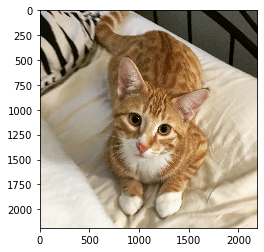

In [50]:
plt.imshow(image)

In [51]:
preprocess = A.Compose([A.Normalize(max_pixel_value=255.0),A.Resize(400,400)])
preprocess

Compose([
  Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
  Resize(always_apply=False, p=1, height=400, width=400, interpolation=1),
], p=1.0, bbox_params={}, keypoint_params={}, additional_targets={})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


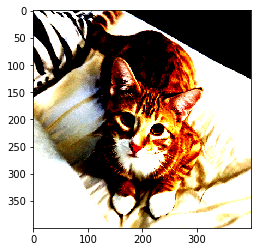

In [52]:
plt.imshow(preprocess(image=image)['image'])
t = torch.tensor(preprocess(image=image)['image'], dtype=torch.float).permute(2,0,1).unsqueeze(0)
# t = t.clamp(0,1)

In [53]:
label = int(model(t).argmax())
labels[label]

'tiger cat'

```














```
# Data loader

In [3]:
from torch.utils import data as D
import pandas as pd

In [4]:
train_path = '../Data/train_cropped/'
test_path = '../Data/test_images/'

df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

filenames = df_train['id_code']
labels = df_train['diagnosis']

In [107]:
class Train_DS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path, labels, filenames):
        """ Intialize the dataset
        """
        self.path = path
        self.file_paths = []
        self.labels = labels
        self.transform = A.Compose([
#                                 A.Normalize(max_pixel_value=1.0),
                                A.VerticalFlip(p=0.25),
                                A.HorizontalFlip(p=0.25),
#                                 A.GaussNoise(var_limit=(0,0.005),p=0.4)
#                                 A.Rotate(limit=15, border_mode=cv2.BORDER_WRAP, p=0.35)
                            ])
        for fn in filenames:
            self.file_paths.append(os.path.join(self.path, fn+".png"))
        self.len = len(self.file_paths)
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = cv2.cvtColor(cv2.imread(self.file_paths[index]), cv2.COLOR_RGB2BGR)/255.
        aug_image = self.transform(image=image)['image']
        return torch.tensor(aug_image, dtype=torch.float).permute(2,0,1), self.labels[index]
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [108]:
train_ds = Train_DS(path=train_path, labels=labels, filenames=filenames)
train_loader = D.DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=4)

In [109]:
dataiter = iter(train_loader)
batch_x, batch_y = dataiter.next()

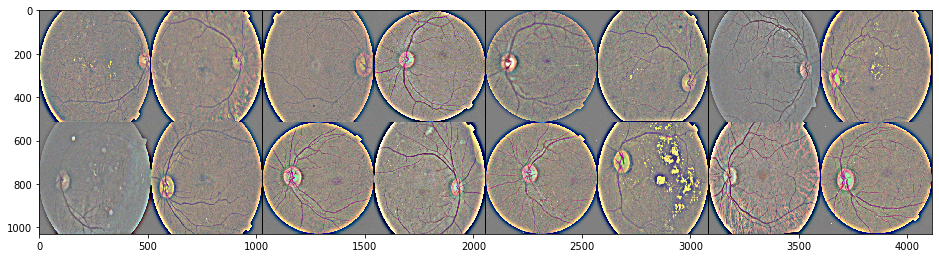

In [110]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg.transpose(1, 2, 0))
    


plt.figure(figsize=(16,8))
imshow(torchvision.utils.make_grid(batch_x))

```














```
# Train

In [ ]:
from tensorboardX import SummaryWriter

In [67]:
params = []

In [68]:
for name, m in model.named_modules():
    if name == 'layer4.2' or name == 'fc':
        params.extend(m.parameters())

In [ ]:
opt = torch.optim.Adam(params=params, lr = 0.001)
model.train()
data_iter = data_loader()

In [ ]:
num_iter = 5000
device = torch.device('cuda')
model = model.to(device=device)

def compute_loss(batch_x, batch_y):
    logits = model(batch_x)
    return F.cross_entropy(logits, batch_y).mean()

for i in range(num_iter):
    batch_x, batch_y = dataiter.next()
    loss = compute_loss(batch_x, batch_y)
    loss.backward()
    opt.step()
    opt.zero_grad()